# Introduction

We examine the topology of business signs along Kloof Street in Cape Town where a total of 191 signs were surveyed. In the first section examines the topology of the signs, establishments with the most or largest signs by area (or by height or width dimentionality), and finally, their spread along the arterial. The analysis is concluded by way of a discriptive analysis, summarasing the statistical nature of the data.

# Development Environment

In [72]:
# Matrix / Frame Configuration
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Plots
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy import stats
import math

# Spatial Mapping
import folium # spatial heatmap

# Data

In [93]:
filename = '/Users/ad/signage-survey/data/signage2015_kloof_street.csv'
df = pd.read_csv(filename)
df.head()

,Erfnumber,sign,Illuminati,1st,3rd,Height,Width,Area,NumberofSi,NrofSidesT,...,latitude,BusinessSh,TenantName,Encroachme,1stParty,3rdParty,Approximat,DateCreate,DateUpdate,hae
0,94836,flatsgn,Yes,No,Yes,20.0,15.0,300.00,1.0,1,...,-33.927335,McDonalds,McDonalds,Yes Certain,McDonalds,H&M,80.0,2015-10-14T13:31:53Z,NaN,71.087371
1,94836,flatsgn,Yes,Yes,No,1.0,1.0,1.00,1.0,1,...,-33.927435,McDonalds,NaN,Yes Certain,McDonalds,NaN,100.0,2015-10-14T13:40:45Z,NaN,64.681593
2,94836,flatsgn,Yes,No,Yes,15.0,10.0,150.00,1.0,1,...,-33.927596,McDonalds,NaN,Yes Certain,McDonalds,Little Dragon,100.0,2015-10-14T13:52:46Z,NaN,64.022530
3,96236,flatsgn,Yes,Yes,No,0.3,4.0,1.20,1.0,1,...,-33.928151,Dark Paradise,NaN,Yes Certain,Dark Paradise,NaN,100.0,2015-10-14T14:09:00Z,NaN,62.453141
4,96236,flatsgn,No,Yes,No,0.5,1.5,0.75,1.0,1,...,-33.928158,Indie,Indie,Yes Certain,Indie,NaN,50.0,2015-10-14T14:13:02Z,NaN,61.440801


The data is multivariate, containing continous and categorical variables, and are measured in different units. _Width_ and _Height_ are measured in metres, while _Area_ is measured in metres-sqaured. The signs' geodetic vertical and horizontal location relative to the prime meridian at Greenwich, and naught at the equator, is measured in _latitude_ and _longitude_ decimal degrees, respectively. The _illum_ feature maps _Illuminated_, hence only one of these are needed, noting that the variables represent a qualitative property, i.e., whether a sign is of type illuminated. Other categorical variables are 'Suburb' and 'sign'. Finally, illuminated signs are a sub-category of sign. 

# 1. Exploratory Data Analysis

## 1.1 Signage Typology

In [94]:
signCount = df['sign'].value_counts().rename_axis('Sign Type').reset_index(name='Count')
signCount.style.background_gradient(cmap='mako_r')

,Sign Type,Count
0,cnopy,102
1,flatsgn,43
2,projctng,31
3,bndrywll,16


Signs are classified in four groups, namely:
* Canopy (cnopy)
* Flat Sign (flatsgn)
* Projecting (projectng)
* Boundary Wall (bdrywl)

Canopy signs are a greater portion of the total at 53.1%, followed by flat signs, and so on. Signs that are illuminatable are indicated with a 'yes' or 'no'; these are comparably more popular amongst flat- and projecting signs, totalling 81% and 68% respectively.

### Signage proportion by Illuminance

In [95]:
# Sign Typology
fig = px.sunburst(df, path=['sign', 'Illuminati'])
fig.update_traces(textinfo="label+percent parent")                  
fig.show()

### Top 10 businesses by total signs

In [96]:
# Top 10 businesses by signage count
top10SignCount = df.groupby('BusinessSh')['sign'].count().sort_values(ascending=False).reset_index()[:10]

fig = px.pie(top10SignCount, values='sign', names='BusinessSh')
fig.show()

### Top 10 businesses by total signage area (on average)

In [97]:
# Top 10 businesses by signage area
top10SignArea = df.groupby('BusinessSh')['Area'].mean().sort_values(ascending=False).reset_index()[:10]
fig = px.pie(top10SignArea, values='Area', names='BusinessSh')
fig.show()

### Top 10 businesses with the tallest signs (on average)

In [98]:
# Top 10 businesses by mean height, i.e., on average businesses with tallest signs
Top10TallestSign = df.groupby('BusinessSh')['Height'].mean().sort_values(ascending=False).reset_index()[:10]

fig = px.pie(Top10TallestSign, values='Height', names='BusinessSh')
fig.show()

### Top 10 businesses with the widest signs (on average)

In [99]:
# Top 10 businesses by mean width, i.e., on avg businesses with widest signs
Top10WidestSign = df.groupby('BusinessSh')['Width'].mean().sort_values(ascending=False).reset_index()[:10]

fig = px.pie(Top10WidestSign, values='Width', names='BusinessSh')
fig.show()

Mean width compared to total width reveals a change in ranking. Arnolds on average has the widest sign (i.e., width = 15m & height = 0.5m)

In [100]:
fig = px.sunburst(df, path=['BusinessSh', 'Illuminati', 'sign'])
fig.update_traces(textinfo="label+percent parent")                  
fig.show()

In [101]:
def filterOut(frameToFilter, attributeName, frameToIterate):
    strng = '{} in ['.format(attributeName)
    check = frameToIterate.shape[0]- 1
    for i, row in frameToIterate.iterrows():
        val = row[attributeName]
        if i < check:
            strng += '"{}", '.format(val)
        else:
            strng += '"{}"]'.format(val)
    #print(strng)
    return frameToFilter.query(strng).sort_values('BusinessSh', ascending=True).reset_index()


fig = px.sunburst(filterOut(df, 'BusinessSh', top10SignCount), 
                  path=['BusinessSh', 'sign', 'Illuminati'])
#fig.update_traces(textinfo="label+percent parent")                  
fig.show()


## 1.2 Spatial Distribution

The heatmaps below show signage hotspots occur between Kotze- and Malan Street, Camp- and Union Streen, and finally Kloof- and Orange Street. Apart from Rheede Street with 12 sign locations, intersections collate signage short off Kloof Street and thus reflect comporably greater concentration. 

In [102]:
# Function for generating a base map
# REF: https://geopandas.org/en/stable/gallery/plotting_with_folium.html
def generateBaseMap(default_location = [-33.929, 18.411], default_zoom_start=100):
    basemap = folium.Map(location=default_location, tiles='Stamen Toner', zoom_start=default_zoom_start)
    return basemap

# Create base map by calling generatebasemap() function
basemap = generateBaseMap()

# Add points to the map
from folium.plugins import HeatMap
HeatMap(df[['latitude', 'longitude']], max_zoom=100).add_to(basemap)

# Display Map
basemap

In [103]:
from folium import Marker
from folium.plugins import MarkerCluster
mc = MarkerCluster()
for idx, row in df.iterrows():
    if not math.isnan(row['longitude']) and not math.isnan(row['latitude']):
        mc.add_child(Marker([row['latitude'], row['longitude']],
                            popup =
                            "Type: " + str(row['sign']) + '<br>' +
                            "Lat: " + str(row['latitude']) + '<br>' +
                            "Long: " + str(row['longitude']) + '<br>'
                            "Area: " + str(row['Area']) + '<br>' +
                            "Business: " + str(row['BusinessSh'])))       
basemap.add_child(mc)

In [104]:
mapSignSize = generateBaseMap()

def color_producer(val):
    if val > 0 and val <= 2:
        return 'mediumblue'
    elif val > 2 and val <= 8:
        return 'red'
    elif val > 8 and val <= 10:
        return 'cyan'
    else:
        return 'magenta'

from folium import Circle

for idx, row in df.iterrows():
    if not math.isnan(row['longitude']) and not math.isnan(row['latitude']):
        Circle(radius=5,
               location=[row['latitude'], row['longitude']],
               color=color_producer(row['Area']),
               popup=
               'Type: ' + str(row['sign']) + '<br>' +
               'Lat: ' + str(row['latitude']) + '<br>' +
               'Long: ' + str(row['longitude']) + '<br>' +
               'Area: ' + str(row['Area']) + '<br>' + 
               'Business: ' + str(row['BusinessSh'])).add_to(mapSignSize)

# Display the map
mapSignSize

# 2. Descriptive Data Analysis

In [105]:
# Calculate the logDimension and append frame with logValue
def calcLog(dimension): 
    var = 'log'+ dimension
    if var in df.columns: # Check if column exist in df
        return var
    else:
        df[var] = np.log(df[dimension]+1)
        return var

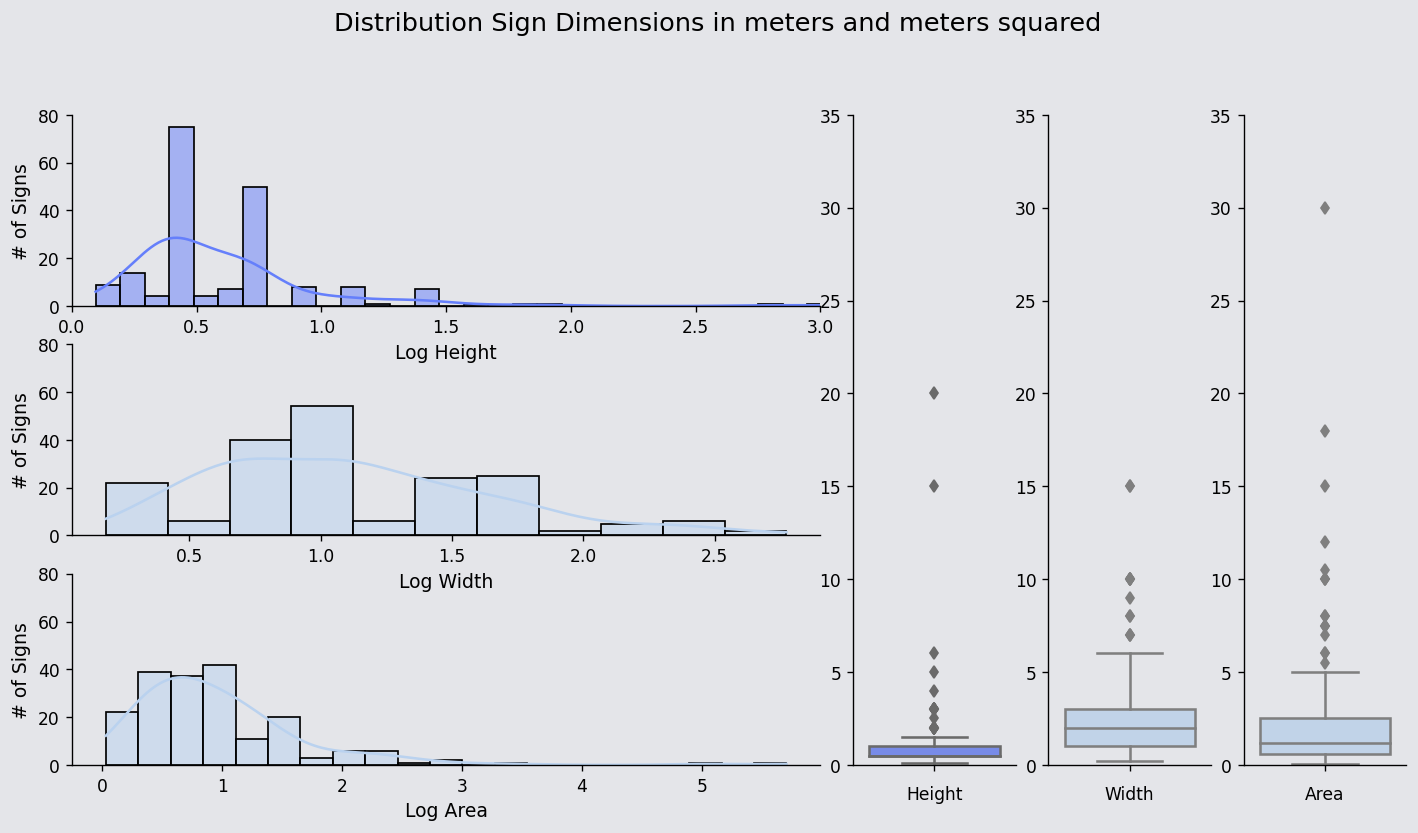

In [106]:
fig = plt.figure(figsize=(14, 7), dpi=123, facecolor='#E4E5E9') # Generate the figure
spec = fig.add_gridspec(ncols=7, nrows=3)

# Configure Distribution Plots
g0 = fig.add_subplot(spec[0, :4])
sns.histplot(df[calcLog('Height')], kde=True, color='#657FFB', edgecolor='black') #kde - kernal density estimate
# sns.histplot(x='Height', data=df, kde=True, color='#657FFB', edgecolor='black') 
plt.ylabel('# of Signs', fontsize=11)
plt.xlabel('Log Height', fontsize=11)
plt.xlim(0, 3)
plt.ylim(0, 80)

g1 = fig.add_subplot(spec[1, :4])
sns.histplot(df[calcLog('Width')], kde=True, color='#BAD2EF', edgecolor='black') 
#sns.histplot(x='Width', data=df, kde=True, color='#BAD2EF', edgecolor='black')
plt.ylabel('# of Signs', fontsize=11)
plt.xlabel('Log Width', fontsize=11)
#plt.xlim(0, 20)
plt.ylim(0, 80)

g2 = fig.add_subplot(spec[2, :4])
sns.histplot(df[calcLog('Area')], kde=True, color='#BAD2EF', edgecolor='black') 
#sns.histplot(x='Width', data=df, kde=True, color='#BAD2EF', edgecolor='black')
plt.ylabel('# of Signs', fontsize=11)
plt.xlabel('Log Area', fontsize=11)
#plt.xlim(0, 20)
plt.ylim(0, 80)

# Configure Box Plots
g3 = fig.add_subplot(spec[:, 4])
sns.boxplot(y=df['Height'], color='#657FFB')
plt.xlabel('Height', labelpad=5, fontsize=10)
plt.ylabel(' ')
plt.ylim(0, 35)

g4 = fig.add_subplot(spec[:, 5])
sns.boxplot(y=df['Width'], color='#BAD2EF')
plt.xlabel('Width', labelpad=5, fontsize=10)
plt.ylabel(' ')
plt.ylim(0, 35)

g5 = fig.add_subplot(spec[:, 6])
sns.boxplot(y=df['Area'], color='#BAD2EF')
plt.xlabel('Area', labelpad=5, fontsize=10)
plt.ylabel(' ')
plt.ylim(0, 35)

for g in [g0, g1, g2, g3, g4, g5]:
    g.patch.set_alpha(0.0)
    g.spines['top'].set_visible(False)
    g.spines['right'].set_visible(False)
    
fig.suptitle('Distribution Sign Dimensions in meters and meters squared', fontsize=15, y=1)
plt.show()

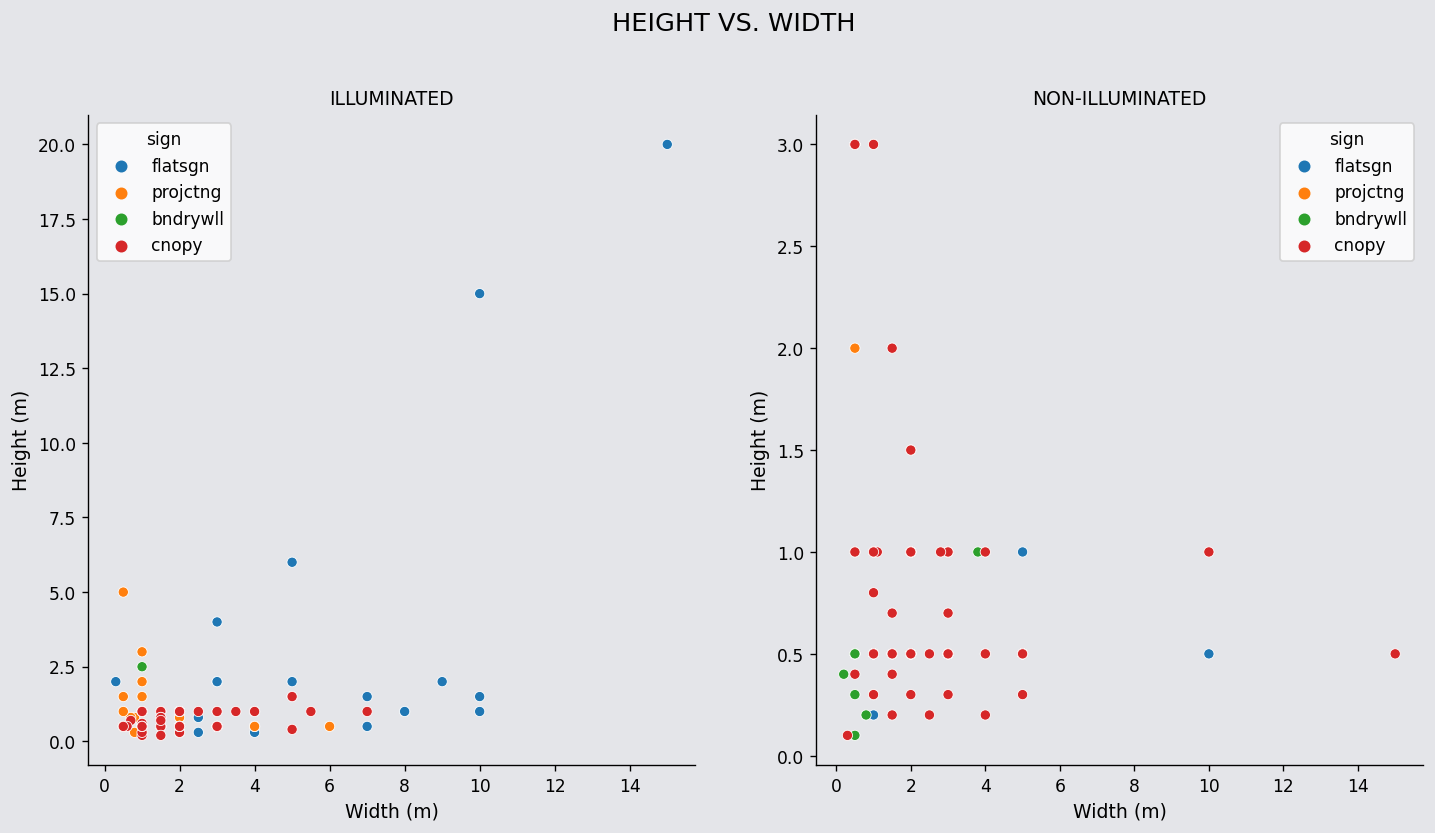

In [108]:
fig = plt.figure(figsize=(14, 7), dpi=123, facecolor='#E4E5E9') # Generate the figure
spec = fig.add_gridspec(ncols=2, nrows=2)

g0 = fig.add_subplot(spec[0:2, :1])
# Calculate Dimensional Ratios
#height_rate = dfStats.eval("Height / Area").rename("height_rate")
sns.scatterplot(data=df.loc[df.Illuminati == "Yes"], 
                x='Width', 
                y='Height', 
                hue='sign')
plt.ylabel('Height (m)', fontsize=11)
plt.xlabel('Width (m)', fontsize=11)
plt.title('ILLUMINATED', fontsize=11)
#plt.xlim(0, 3)
#plt.ylim(0, 80)

g1 = fig.add_subplot(spec[0:2, 1:2])
# Calculate Dimensional Ratios
#height_rate = dfStats.eval("Height / Area").rename("height_rate")
sns.scatterplot(data=df.loc[df.Illuminati == "No" ], 
                x='Width', 
                y='Height', 
                hue='sign')
plt.ylabel('Height (m)', fontsize=11)
plt.xlabel('Width (m)', fontsize=11)
plt.title('NON-ILLUMINATED', fontsize=11)
#plt.xlim(0, 3)
#plt.ylim(0, 80)

for g in [g0, g1]:
    g.patch.set_alpha(0.0)
    g.spines['top'].set_visible(False)
    g.spines['right'].set_visible(False)
    
fig.suptitle('HEIGHT VS. WIDTH', fontsize=15, y=1)
plt.show()

## 2.1 Check for Normality

The above plots reveal that the data is non-normaly distributed. Below we confirm this by use of the probability plot and the several best fit tests. The code for the best fit test is taken from Haslwanter (2016), noting that for intermediate sample sizes, the Lilliefors-test is recommended (Haslwanter, 2016). 

### 2.1.1 Best Fit Tests

<ipython-input-109-fad2d9a3e250>:7: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

<ipython-input-109-fad2d9a3e250>:8: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



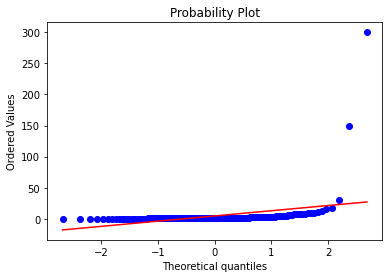

BEST FIT TESTS FOR NORMALITY:

p-values for all 192 data points: ----------------
Omnibus               5.805881e-82
Shapiro-Wilk          6.553585e-29
Lilliefors            1.000000e-03
Kolmogorov-Smirnov    3.918015e-32
dtype: float64

p-values for the first 96 data points: ----------------
Omnibus               1.352140e-39
Shapiro-Wilk          1.241750e-20
Lilliefors            1.000000e-03
Kolmogorov-Smirnov    2.030115e-15
dtype: float64

The Area is non-normally distributed, i.e., it reflects a statistically significant difference (p < 0.05):
0.0009999999999998899


In [109]:
# REF: https://github.com/thomas-haslwanter/statsintro_python/blob/master/ISP/Code_Quantlets/07_CheckNormality_CalcSamplesize/checkNormality/ISP_checkNormality.py

from statsmodels.stats.diagnostic import lilliefors

def check_normality(data, name):
    # Holder for test results
    pVals = pd.Series()
    pFewVals = pd.Series()
    
    #Portion out half of the dataset
    fewVal = 96 #len(data)
    fewData = data[:fewVal]

    # Normal Distribution
    #sns.distplot(data, fit=norm);
    #fig = plt.figure()
    
    # GRAPHICAL TEST: PROBABILITY PLOT
    _ = stats.probplot(data, plot=plt)
    plt.show()

    # OMNIBUS TEST
    # Scipy normality test is based on the D-Agostino and Pearsons test that
    # combines skey and kurtosis to produce an Omnibus Test of normality
    _, pVals['Omnibus'] = stats.normaltest(data)
    _, pFewVals['Omnibus'] = stats.normaltest(fewData)

    # SHAPIRO-WILK TEST
    _, pVals['Shapiro-Wilk'] = stats.shapiro(data)
    _, pFewVals['Shapiro-Wilk'] = stats.shapiro(fewData)

    # LILLIEFORS TEST
    _, pVals['Lilliefors'] = lilliefors(data)
    _, pFewVals['Lilliefors'] = lilliefors(fewData)

    # KOLMOGOROV-SMIRNOV TEST (not for sample sizes < 300)
    _, pVals['Kolmogorov-Smirnov'] = stats.kstest((data-np.mean(data))/np.std(data, ddof=1), 'norm')
    _, pFewVals['Kolmogorov-Smirnov'] = stats.kstest((fewData-np.mean(fewData))/np.std(fewData, ddof=1), 'norm')
    
    #Print results
    print('BEST FIT TESTS FOR NORMALITY:\n')
    print('p-values for all {0} data points: ----------------'.format(len(data)))
    print(pVals)
    
    print('\np-values for the first {0} data points: ----------------'.format(fewVal))
    print(pFewVals)
    
    if pVals['Lilliefors'] > 0.05:
        print('\nData is normally distributed')
    else:
        print('\nThe ' +name+ ' is non-normally distributed, i.e., it reflects a statistically significant difference (p < 0.05):')
    # --- >>> STOP stats <<< ---
    
    return pVals['Lilliefors']
    

if __name__ == '__main__':
    p = check_normality(df['Area'], 'Area')   
    print(p)


The test above show that the Area is non-normally distributed. The probability plot reveals several outliers, however, these outsized signs are confirmed not to be a measurement error. Next we investigate the effect on normality by removing the outliers.

In [110]:
# Sort Data in Descending Order By Area
df.sort_values(by = 'Area', ascending=False)[:10]

,Erfnumber,sign,Illuminati,1st,3rd,Height,Width,Area,NumberofSi,NrofSidesT,...,Encroachme,1stParty,3rdParty,Approximat,DateCreate,DateUpdate,hae,logHeight,logWidth,logArea
0,94836,flatsgn,Yes,No,Yes,20.0,15.0,300.0,1.0,1,...,Yes Certain,McDonalds,H&M,80.0,2015-10-14T13:31:53Z,NaN,71.087371,3.044522,2.772589,5.707110
2,94836,flatsgn,Yes,No,Yes,15.0,10.0,150.0,1.0,1,...,Yes Certain,McDonalds,Little Dragon,100.0,2015-10-14T13:52:46Z,NaN,64.022530,2.772589,2.397895,5.017280
30,96068,flatsgn,Yes,No,Yes,6.0,5.0,30.0,1.0,1,...,Yes Certain,Buitenkloof studios,Hey fashionista,100.0,2015-10-16T12:22:58Z,NaN,73.550398,1.945910,1.791759,3.433987
9,94839,flatsgn,Yes,No,Yes,2.0,9.0,18.0,1.0,1,...,Yes Certain,I love NY,New Edge,250.0,2015-10-15T13:55:09Z,NaN,76.331428,1.098612,2.302585,2.944439
22,161541,flatsgn,Yes,Yes,No,1.5,10.0,15.0,1.0,1,...,Yes Certain,Wellness warehouse,NaN,100.0,2015-10-15T15:00:38Z,NaN,76.687140,0.916291,2.397895,2.772589
15,161541,flatsgn,Yes,Yes,No,4.0,3.0,12.0,1.0,1,...,Yes Certain,Knead,NaN,150.0,2015-10-15T15:54:42Z,NaN,76.588669,1.609438,1.386294,2.564949
35,2250,flatsgn,Yes,Yes,No,1.5,7.0,10.5,1.0,1,...,Yes Certain,Premier,NaN,100.0,2015-10-19T13:22:07Z,NaN,116.367718,0.916291,2.079442,2.442347
32,163560,flatsgn,Yes,Yes,No,1.0,10.0,10.0,1.0,1,...,Yes Certain,Royo Kloof,NaN,60.0,2015-10-19T11:03:46Z,2015-10-19T11:27:27Z,86.359295,0.693147,2.397895,2.397895
7,94839,flatsgn,Yes,No,Yes,2.0,5.0,10.0,1.0,1,...,Yes Certain,Cell Corner,New Edge,300.0,2015-10-15T13:43:34Z,NaN,71.866455,1.098612,1.791759,2.397895
145,96032,cnopy,No,Yes,No,1.0,10.0,10.0,1.0,1,...,Yes Certain,Chas Everitt,NaN,250.0,2015-10-16T15:17:17Z,NaN,74.295615,0.693147,2.397895,2.397895


In [111]:
# Remove outliers i.e., Areas >= 10.5
df_outlier_removed = df.loc[df.Area < 10.5]
df_outlier_removed.sort_values(by='Area', ascending=False)[:10]

,Erfnumber,sign,Illuminati,1st,3rd,Height,Width,Area,NumberofSi,NrofSidesT,...,Encroachme,1stParty,3rdParty,Approximat,DateCreate,DateUpdate,hae,logHeight,logWidth,logArea
32,163560,flatsgn,Yes,Yes,No,1.0,10.0,10.0,1.0,1,...,Yes Certain,Royo Kloof,NaN,60.0,2015-10-19T11:03:46Z,2015-10-19T11:27:27Z,86.359295,0.693147,2.397895,2.397895
7,94839,flatsgn,Yes,No,Yes,2.0,5.0,10.0,1.0,1,...,Yes Certain,Cell Corner,New Edge,300.0,2015-10-15T13:43:34Z,NaN,71.866455,1.098612,1.791759,2.397895
145,96032,cnopy,No,Yes,No,1.0,10.0,10.0,1.0,1,...,Yes Certain,Chas Everitt,NaN,250.0,2015-10-16T15:17:17Z,NaN,74.295615,0.693147,2.397895,2.397895
42,3223,flatsgn,Yes,Yes,No,1.0,8.0,8.0,1.0,1,...,Yes Certain,Mark miller furniture design,NaN,500.0,2015-10-19T11:13:46Z,NaN,0.000000,0.693147,2.197225,2.197225
25,96229,flatsgn,Yes,No,No,1.0,8.0,8.0,1.0,1,...,Yes Certain,Kwik spar,NaN,150.0,2015-10-16T10:20:33Z,NaN,66.922085,0.693147,2.197225,2.197225
5,96137,flatsgn,Yes,Yes,No,1.5,5.0,7.5,1.0,1,...,Yes Certain,Rheede street mall,NaN,250.0,2015-10-15T12:43:41Z,NaN,64.733093,0.916291,1.791759,2.140066
175,94630,cnopy,No,Yes,No,0.5,15.0,7.5,1.0,1,...,Yes Certain,A,NaN,2500.0,2015-10-19T08:30:25Z,NaN,0.000000,0.405465,2.772589,2.140066
107,96137,cnopy,Yes,Yes,No,1.5,5.0,7.5,1.0,1,...,Yes Certain,Sawaddee,NaN,2000.0,2015-10-15T12:35:19Z,NaN,64.397654,0.916291,1.791759,2.140066
92,94836,cnopy,Yes,Yes,No,1.0,7.0,7.0,2.0,1,...,Yes Certain,McDonalds,NaN,2000.0,2015-10-14T13:25:52Z,NaN,78.362064,0.693147,2.079442,2.079442
17,161541,flatsgn,Yes,Yes,No,2.0,3.0,6.0,1.0,1,...,Yes Certain,Woolworths,NaN,100.0,2015-10-15T16:02:13Z,NaN,69.134377,1.098612,1.386294,1.945910


<ipython-input-109-fad2d9a3e250>:7: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

<ipython-input-109-fad2d9a3e250>:8: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



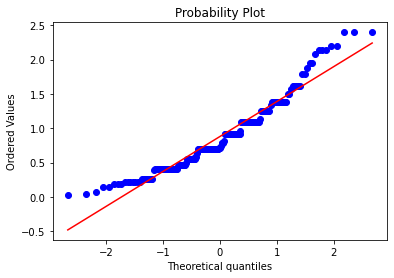

BEST FIT TESTS FOR NORMALITY:

p-values for all 185 data points: ----------------
Omnibus               2.922019e-05
Shapiro-Wilk          3.596243e-07
Lilliefors            1.000000e-03
Kolmogorov-Smirnov    2.572961e-03
dtype: float64

p-values for the first 96 data points: ----------------
Omnibus               0.007709
Shapiro-Wilk          0.000078
Lilliefors            0.001000
Kolmogorov-Smirnov    0.005294
dtype: float64

The Area is non-normally distributed, i.e., it reflects a statistically significant difference (p < 0.05):
0.0009999999999998899


In [112]:
# Check whether the removal of outliers has made improvement on the data's normality.
print(check_normality(df_outlier_removed[calcLog('Area')], 'Area'))

After removing the extreme outliers the data still reflects a non-normal distribution.

## 2.2 Tests for Categorical Data (i.e., Non Parametric Tests)

Since the categorical data is non-interval, test for normality is not necessary (Anwar 2021; Wallis 2021). The categorical variables in question are those identified earlier in section 1.1—i.e., the type of signs.

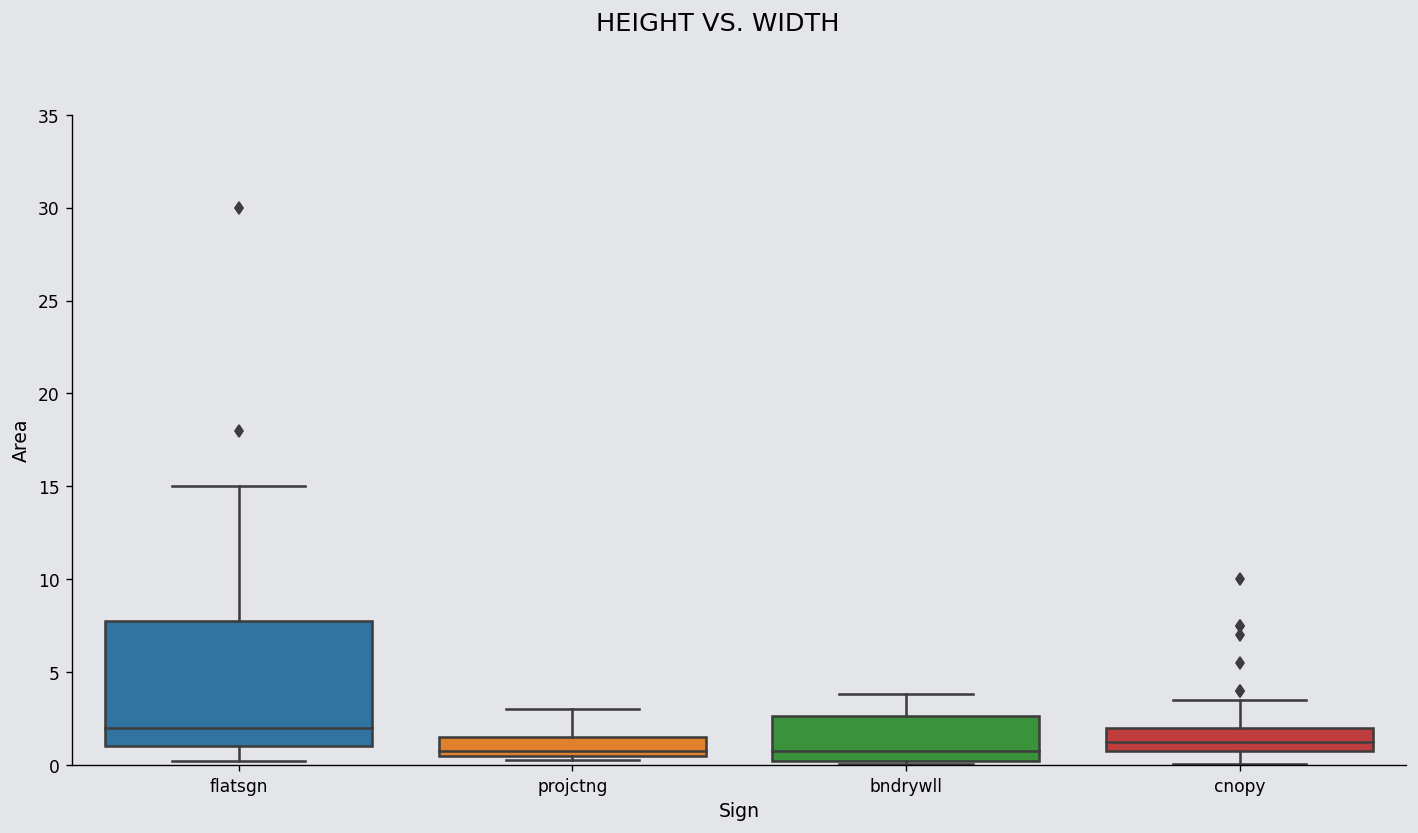

In [113]:
fig = plt.figure(figsize=(14, 7), dpi=123, facecolor='#E4E5E9') # Generate the figure
spec = fig.add_gridspec(ncols=1, nrows=2)

g0 = fig.add_subplot(spec[0:2, :1])
# Calculate Dimensional Ratios
#height_rate = dfStats.eval("Height / Area").rename("height_rate")
sns.boxplot(data=df, 
                x='sign', 
                y='Area')
plt.ylabel('Area', fontsize=11)
plt.xlabel('Sign', fontsize=11)
#plt.xlim(0, 3)
plt.ylim(0, 35)

for g in [g0]:
    g.patch.set_alpha(0.0)
    g.spines['top'].set_visible(False)
    g.spines['right'].set_visible(False)
    
fig.suptitle('HEIGHT VS. WIDTH', fontsize=15, y=1)
plt.show()

# References

Haslwanter, T. (2016). An Introduction to Statistics with Python. 

Wallis, Jamie. (2021). Re: Normality test for categorical variables?. Retrieved from: https://www.researchgate.net/post/Normality_test_for_categorical_variables/60c45303e006b91214360cf7/citation/download. 

Anwar, Imran. (2021). Re: Normality test for categorical variables?. Retrieved from: https://www.researchgate.net/post/Normality_test_for_categorical_variables/60c45a2d04fe610c7216412b/citation/download. 